# Build Chatbots That Know Your Business (with MongoDB and Cohere)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/rag/rag_chatbot_with_cohere_and_mongodb.ipynb)

 **What you will learn:**
 * How to empower leverage semantic search on customer or operational data in MongoDB Atlas.
 * Pass retrieved data to Cohere’s Command R+ generative model for retrieval-augmented generation (RAG).
 * Develop and deploy a RAG-optimized user interface for your app.
 * Create a conversation data store for your RAG chatbot using MongoDB

**Use Case**: Develop an advanced chatbot assistant that provides asset managers with information and actionable insights on technology company market reports.


## Introduction

- What is Cohere?
- What is MongoDB?
- How Cohere and MongoDB work together?

### What is Cohere?

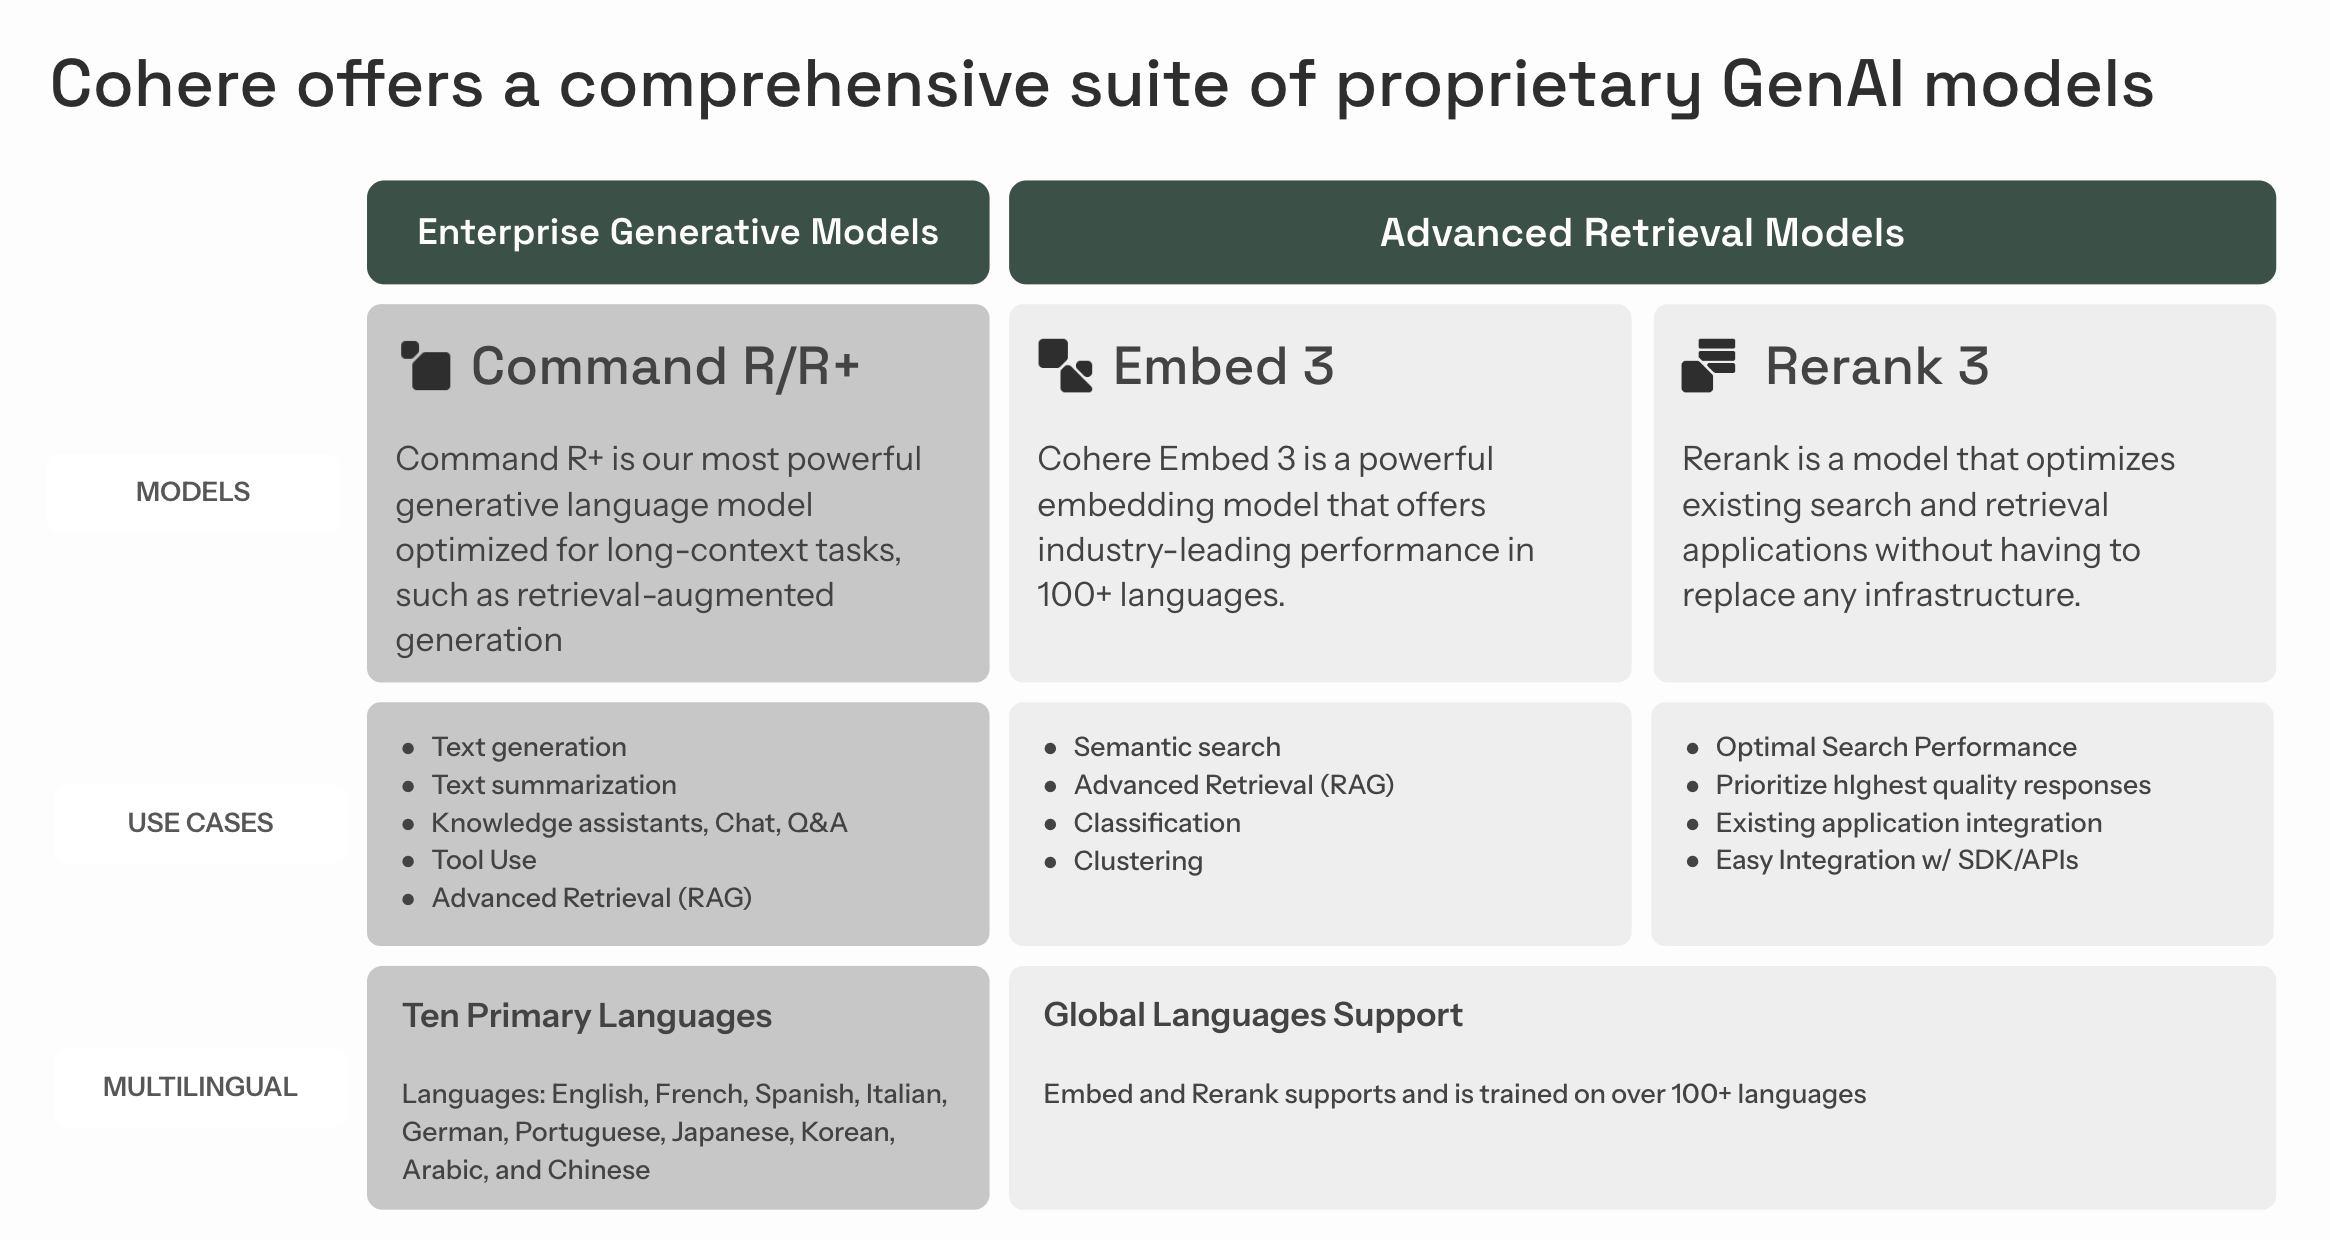

### What is MongoDB?

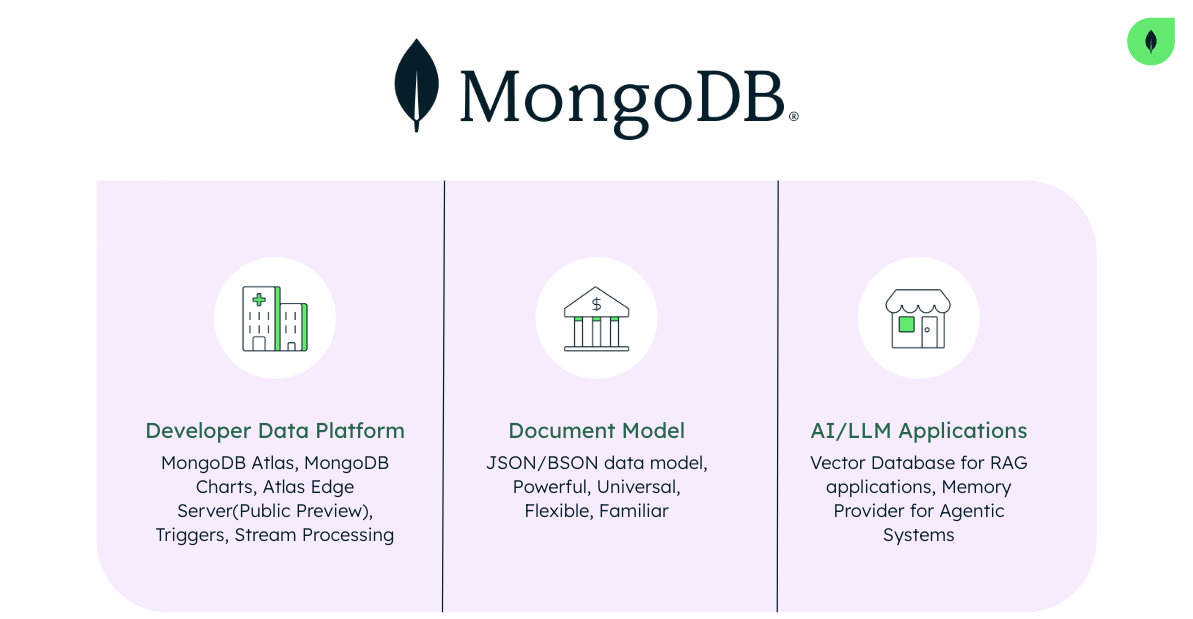

### What exactly are we showing today?

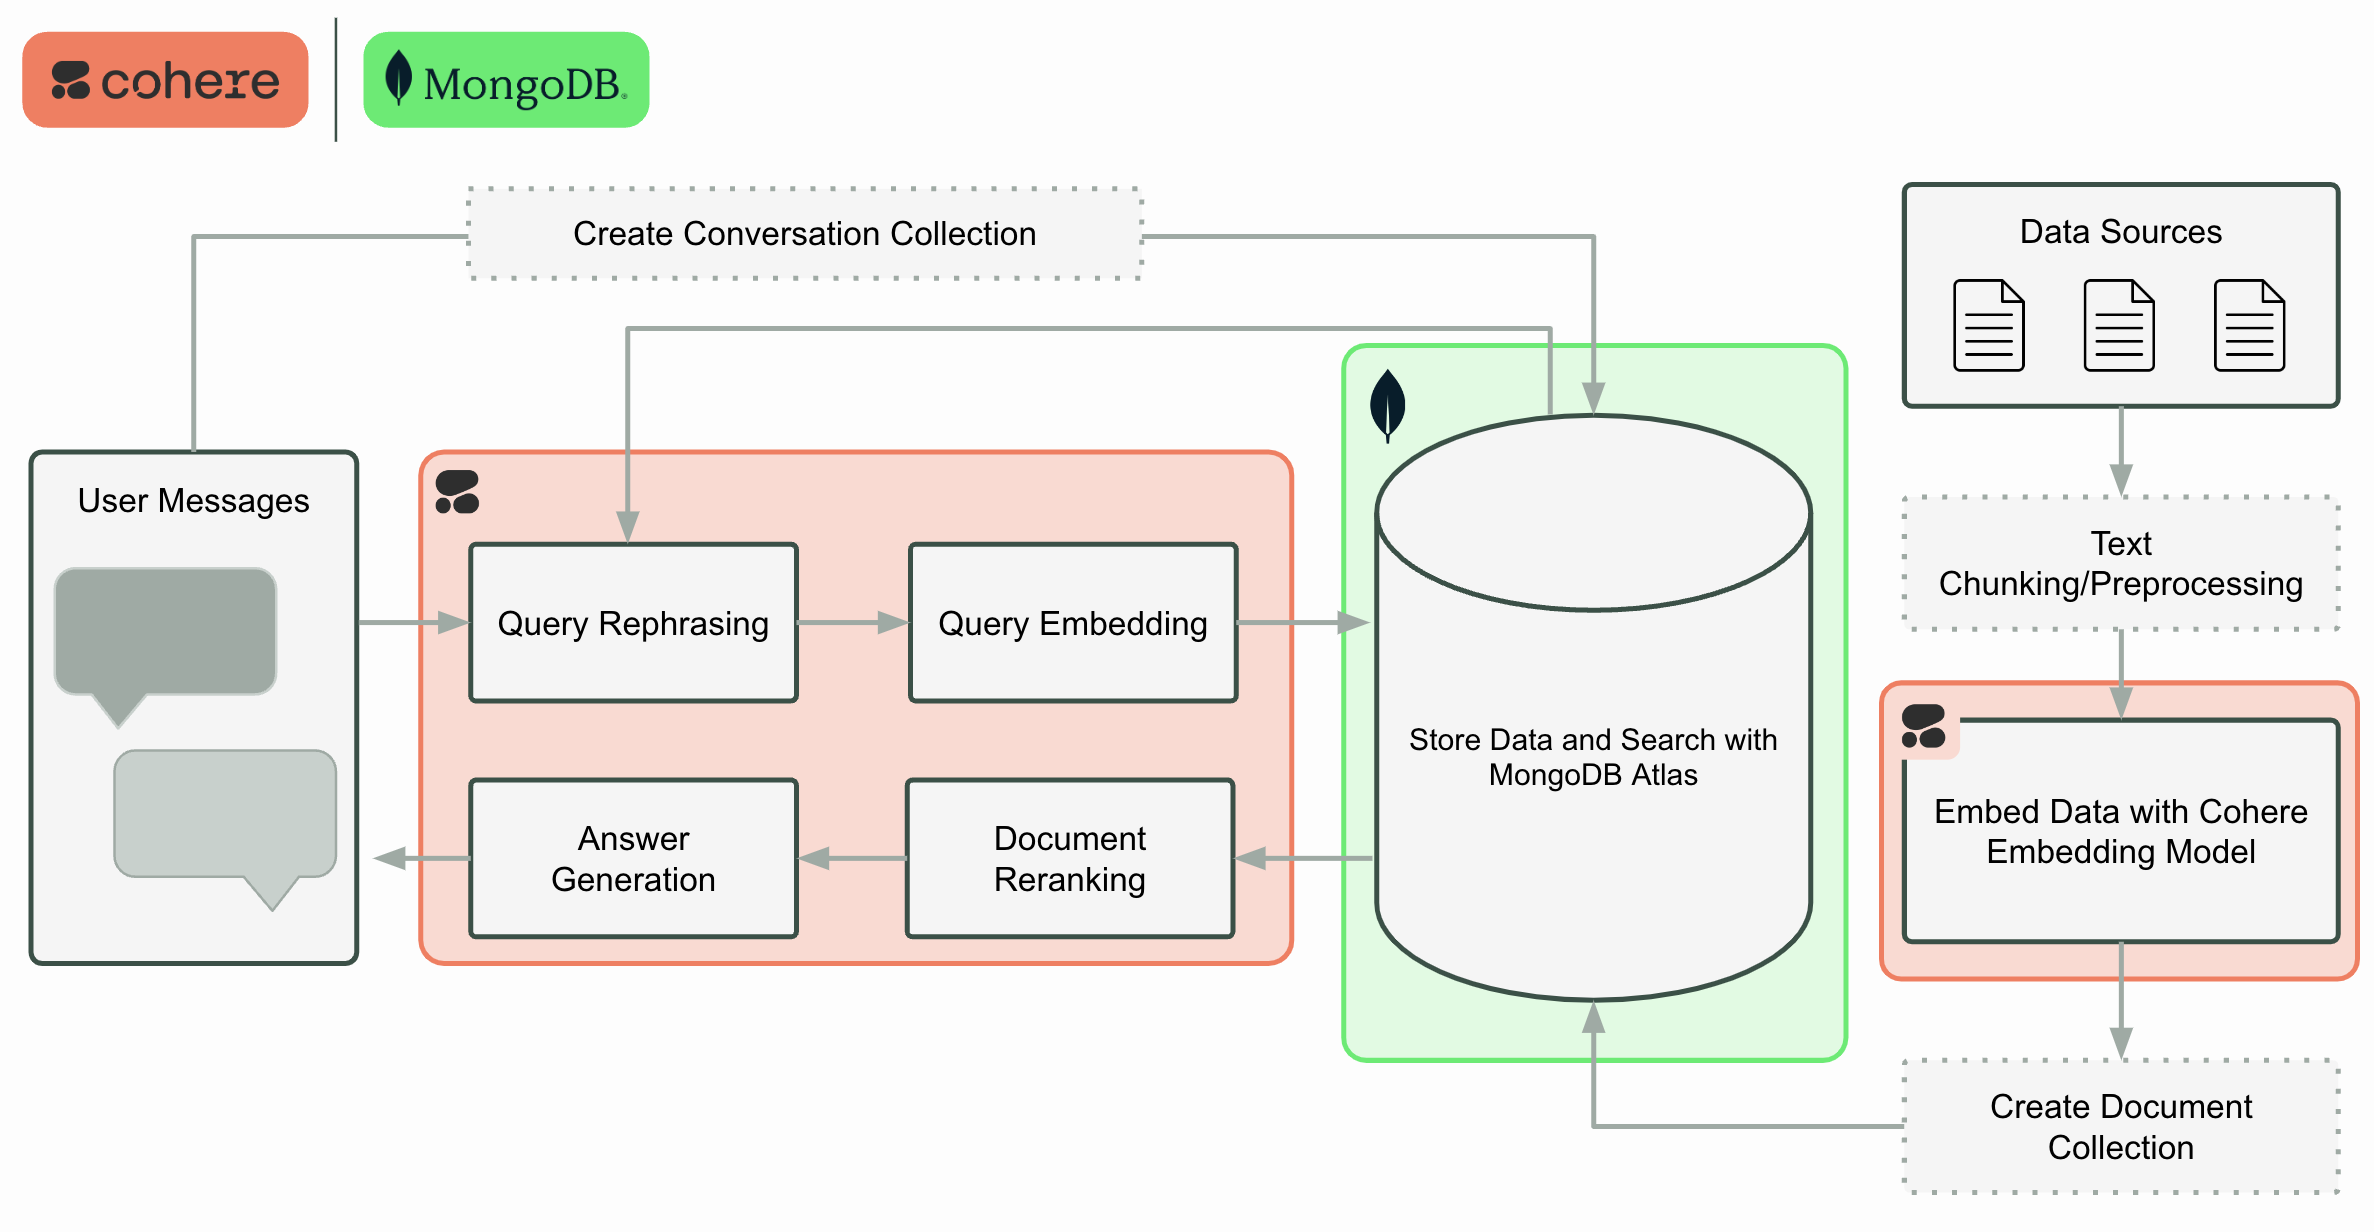

## Step 1: Install libaries and Set Environment Variables

🚨Critical Security Reminder: Safeguard your production environment by never committing sensitive information, such as environment variable values, to public repositories. This practice is essential for maintaining the security and integrity of your systems.

Libraries:
* `cohere`: A Python library for accessing Cohere's large language models, enabling natural language processing tasks like text generation, classification, and embedding.
* `pymongo`: The recommended Python driver for MongoDB, allowing Python applications to interact with MongoDB databases for data storage and retrieval.
* `datasets`: A library by Hugging Face that provides easy access to a wide range of datasets for machine learning and natural language processing tasks.
*`tqdm`: A fast, extensible progress bar library for Python, useful for displaying progress in long-running operations or loops.


In [26]:
!pip install --quiet datasets tqdm cohere pymongo

In [27]:
import os
import cohere

os.environ["COHERE_API_KEY"] = ""
co = cohere.Client(os.environ.get("COHERE_API_KEY"))

os.environ["HF_TOKEN"] = ""

## Step 2: Data Loading and Preparation
**Dataset Information**

This dataset contains detailed information about multiple technology companies in the Information Technology sector. For each company, the dataset includes:

1. Company name and stock ticker symbol
2. Market analysis reports for recent years (typically 2023 and 2024), which include:
  - Title and author of the report
  - Date of publication
  - Detailed content covering financial performance, product innovations, market position, challenges, and future outlook
  - Stock recommendations and price targets

3. Key financial metrics such as:
  - Current stock price
  - 52-week price range
  - Market capitalization
  - Price-to-earnings (P/E) ratio
  - Dividend yield


4. Recent news items, typically including:
  - Date of the news
  - Headline
  - Brief summary

The market analysis reports provide in-depth information about each company's performance, innovations, challenges, and future prospects. They offer insights into the companies' strategies, market positions, and potential for growth.

In [28]:
import pandas as pd
from datasets import load_dataset

# Make sure you have an Hugging Face token(HF_TOKEN) in your development environemnt before running the code below
# How to get a token: https://huggingface.co/docs/hub/en/security-tokens
# https://huggingface.co/datasets/MongoDB/fake_tech_companies_market_reports
dataset = load_dataset("MongoDB/fake_tech_companies_market_reports", split="train", streaming=True)
dataset_df = dataset.take(100)

# Convert the dataset to a pandas dataframe
dataset_df = pd.DataFrame(dataset_df)
dataset_df.head(5)

,recent_news,reports,company,ticker,key_metrics,sector
0,"[{'date': '2024-06-09', 'headline': 'CyberDefe...","[{'author': 'Taylor Smith, Technology Sector L...",CyberDefense Dynamics,CDDY,"{'52_week_range': {'high': 387.3, 'low': 41.63...",Information Technology
1,"[{'date': '2024-07-04', 'headline': 'CloudComp...","[{'author': 'Casey Jones, Chief Market Strateg...",CloudCompute Pro,CCPR,"{'52_week_range': {'high': 524.23, 'low': 171....",Information Technology
2,"[{'date': '2024-06-27', 'headline': 'VirtualRe...","[{'author': 'Sam Brown, Head of Equity Researc...",VirtualReality Systems,VRSY,"{'52_week_range': {'high': 530.59, 'low': 56.4...",Information Technology
3,"[{'date': '2024-07-06', 'headline': 'BioTech I...","[{'author': 'Riley Smith, Senior Tech Analyst'...",BioTech Innovations,BTCI,"{'52_week_range': {'high': 366.55, 'low': 124....",Information Technology
4,"[{'date': '2024-06-26', 'headline': 'QuantumCo...","[{'author': 'Riley Garcia, Senior Tech Analyst...",QuantumComputing Inc,QCMP,"{'52_week_range': {'high': 231.91, 'low': 159....",Information Technology


In [29]:
# Data Preparation
def combine_attributes(row):
  combined = f"{row['company']} {row['sector']} "

  # Add reports information
  for report in row['reports']:
    combined += f"{report['year']} {report['title']} {report['author']} {report['content']} "

  # Add recent news information
  for news in row['recent_news']:
    combined += f"{news['headline']} {news['summary']} "

  return combined.strip()

In [30]:
# Add the new column 'combined_attributes'
dataset_df['combined_attributes'] = dataset_df.apply(combine_attributes, axis=1)

In [31]:
# Display the first few rows of the updated dataframe
dataset_df[['company', 'ticker', 'combined_attributes']].head()

,company,ticker,combined_attributes
0,CyberDefense Dynamics,CDDY,CyberDefense Dynamics Information Technology 2...
1,CloudCompute Pro,CCPR,CloudCompute Pro Information Technology 2023 C...
2,VirtualReality Systems,VRSY,VirtualReality Systems Information Technology ...
3,BioTech Innovations,BTCI,BioTech Innovations Information Technology 202...
4,QuantumComputing Inc,QCMP,QuantumComputing Inc Information Technology 20...


## Step 3: Embedding Generation with Cohere

In [32]:
from tqdm import tqdm

def get_embedding(text: str, input_type: str="search_document") -> list[float]:
  if not text.strip():
    print("Attempted to get embedding for empty text.")
    return []

  model = "embed-english-v3.0"
  response = co.embed(
    texts=[text],
    model=model,
    input_type=input_type, # Used for embeddings of search queries run against a vector DB to find relevant documents
    embedding_types=['float']
  )

  return response.embeddings.float[0]

# Apply the embedding function with a progress bar
tqdm.pandas(desc="Generating embeddings")
dataset_df["embedding"] = dataset_df['combined_attributes'].progress_apply(get_embedding)

print(f"We just computed {len(dataset_df['embedding'])} embeddings.")

Generating embeddings: 100%|██████████| 63/63 [00:07<00:00,  8.85it/s]

We just computed 63 embeddings.


In [33]:
dataset_df.head()

,recent_news,reports,company,ticker,key_metrics,sector,combined_attributes,embedding
0,"[{'date': '2024-06-09', 'headline': 'CyberDefe...","[{'author': 'Taylor Smith, Technology Sector L...",CyberDefense Dynamics,CDDY,"{'52_week_range': {'high': 387.3, 'low': 41.63...",Information Technology,CyberDefense Dynamics Information Technology 2...,"[0.01210022, -0.03466797, -0.017562866, -0.025..."
1,"[{'date': '2024-07-04', 'headline': 'CloudComp...","[{'author': 'Casey Jones, Chief Market Strateg...",CloudCompute Pro,CCPR,"{'52_week_range': {'high': 524.23, 'low': 171....",Information Technology,CloudCompute Pro Information Technology 2023 C...,"[-0.058563232, -0.06323242, -0.037139893, -0.0..."
2,"[{'date': '2024-06-27', 'headline': 'VirtualRe...","[{'author': 'Sam Brown, Head of Equity Researc...",VirtualReality Systems,VRSY,"{'52_week_range': {'high': 530.59, 'low': 56.4...",Information Technology,VirtualReality Systems Information Technology ...,"[0.024154663, -0.022872925, -0.01751709, -0.05..."
3,"[{'date': '2024-07-06', 'headline': 'BioTech I...","[{'author': 'Riley Smith, Senior Tech Analyst'...",BioTech Innovations,BTCI,"{'52_week_range': {'high': 366.55, 'low': 124....",Information Technology,BioTech Innovations Information Technology 202...,"[0.020736694, -0.041046143, -0.0029773712, -0...."
4,"[{'date': '2024-06-26', 'headline': 'QuantumCo...","[{'author': 'Riley Garcia, Senior Tech Analyst...",QuantumComputing Inc,QCMP,"{'52_week_range': {'high': 231.91, 'low': 159....",Information Technology,QuantumComputing Inc Information Technology 20...,"[-0.009757996, -0.04815674, 0.039611816, 0.023..."


## Step 4: MongoDB Vector Database and Connection Setup


MongoDB acts as both an operational and a vector database for the RAG system.
MongoDB Atlas specifically provides a database solution that efficiently stores, queries and retrieves vector embeddings.

Creating a database and collection within MongoDB is made simple with MongoDB Atlas.

1. First, register for a [MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register). For existing users, sign into MongoDB Atlas.
2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/). Select Atlas UI as the procedure to deploy your first cluster.
3. Create the database: `asset_management_use_case`.
4. Within the database ` asset_management_use_case`, create the collection `market_reports`.
5. Create a [vector search index](https://www.mongodb.com/docs/atlas/atlas-vector-search/create-index/#procedure/) named vector_index for the ‘listings_reviews’ collection. This index enables the RAG application to retrieve records as additional context to supplement user queries via vector search. Below is the JSON definition of the data collection vector search index.

Your vector search index created on MongoDB Atlas should look like below:

```
{
  "fields": [
    {
      "numDimensions": 1024,
      "path": "embedding",
      "similarity": "cosine",
      "type": "vector"
    }
  ]
}

```

Follow MongoDB’s [steps to get the connection](https://www.mongodb.com/docs/manual/reference/connection-string/) string from the Atlas UI. After setting up the database and obtaining the Atlas cluster connection URI, securely store the URI within your development environment.

In [34]:
import os
os.environ["MONGO_URI"] = ""

In [35]:
import pymongo

def get_mongo_client(mongo_uri):
  """Establish and validate connection to the MongoDB."""

  client = pymongo.MongoClient(mongo_uri, appname="devrel.showcase.rag.cohere_mongodb.python")

  # Validate the connection
  ping_result = client.admin.command('ping')
  if ping_result.get('ok') == 1.0:
    # Connection successful
    print("Connection to MongoDB successful")
    return client
  else:
    print("Connection to MongoDB failed")
  return None

MONGO_URI = os.environ["MONGO_URI"]

if not MONGO_URI:
  print("MONGO_URI not set in environment variables")

mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "asset_management_use_case"
COLLECTION_NAME = "market_reports"

db = mongo_client.get_database(DB_NAME)
collection = db.get_collection(COLLECTION_NAME)

Connection to MongoDB successful


In [36]:
# Delete any existing records in the collection
collection.delete_many({})

DeleteResult({'n': 63, 'electionId': ObjectId('7fffffff000000000000002b'), 'opTime': {'ts': Timestamp(1721913981, 63), 't': 43}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1721913981, 63), 'signature': {'hash': b'cU;+\xe3\xbdRc\t\x80\xad\x03\x16\x11\x18\xe6s\xebF\x01', 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1721913981, 63)}, acknowledged=True)

## Step 5: Data Ingestion

MongoDB's Document model and its compatibility with Python dictionaries offer several benefits for data ingestion.

* Document-oriented structure:
  * MongoDB stores data in JSON-like documents: BSON(Binary JSON).
  * This aligns naturally with Python dictionaries, allowing for seamless data representation using key value pair data structures.
* Schema flexibility:
  * MongoDB is schema-less, meaning each document in a collection can have a different structure.
  * This flexibility matches Python's dynamic nature, allowing you to ingest varied data structures without predefined schemas.
* Efficient ingestion:
  * The similarity between Python dictionaries and MongoDB documents allows for direct ingestion without complex transformations.
  * This leads to faster data insertion and reduced processing overhead.

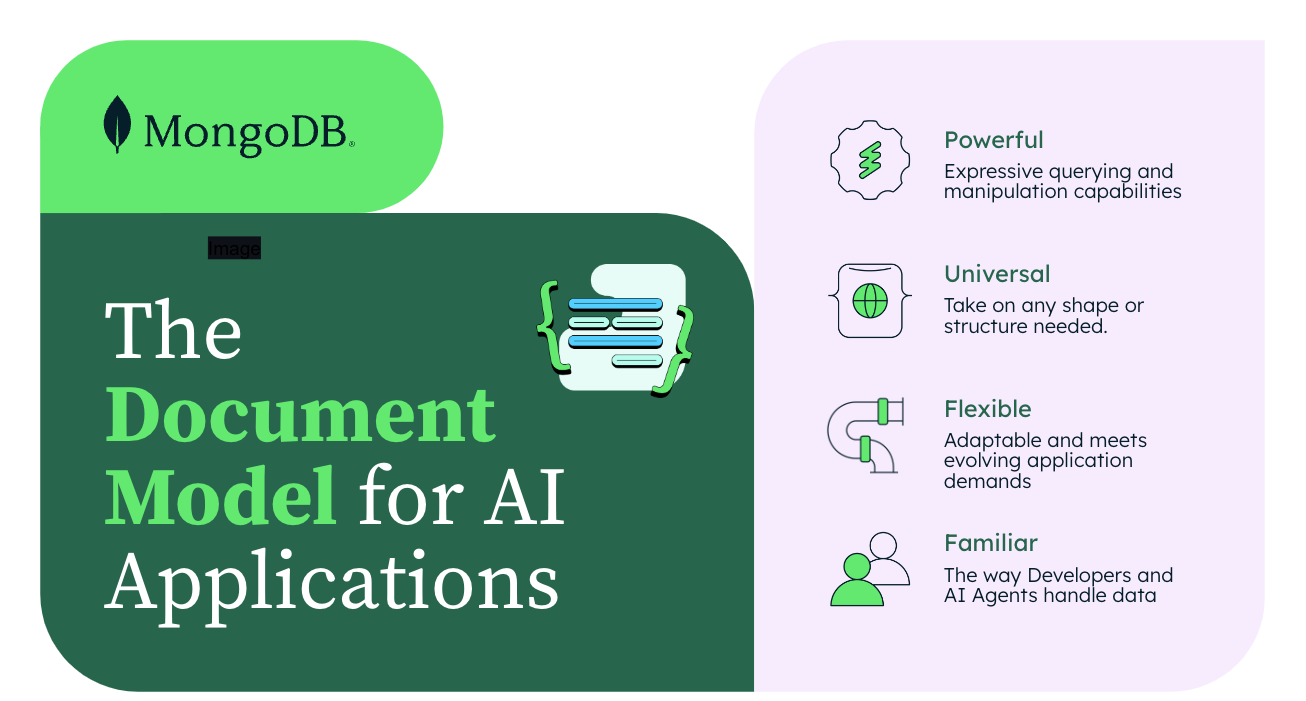

In [37]:
documents = dataset_df.to_dict('records')
collection.insert_many(documents)

print("Data ingestion into MongoDB completed")

Data ingestion into MongoDB completed


## Step 6: MongoDB Query language and Vector Search

**Query flexibility**

MongoDB's query language is designed to work well with document structures, making it easy to query and manipulate ingested data using familiar Python-like syntax.


**Aggregation Pipeline**

MongoDB's aggregation pipelines is a powerful feature of the MongoDB Database that allows for complex data processing and analysis within the database.
Aggregation pipeline can be thought of similarly to pipelines in data engineering or machine learning, where processes operate sequentially, each stage taking an input, performing operations, and providing an output for the next stage.

**Stages**

Stages are the building blocks of an aggregation pipeline.
Each stage represents a specific data transformation or analysis operation.
Common stages include:
  - `$match`: Filters documents (similar to WHERE in SQL)
  - `$group`: Groups documents by specified fields
  - `$sort`: Sorts the documents
  - `$project`: Reshapes documents (select, rename, compute fields)
  - `$limit`: Limits the number of documents
  - `$unwind`: Deconstructs array fields
  - `$lookup`: Performs left outer joins with other collections



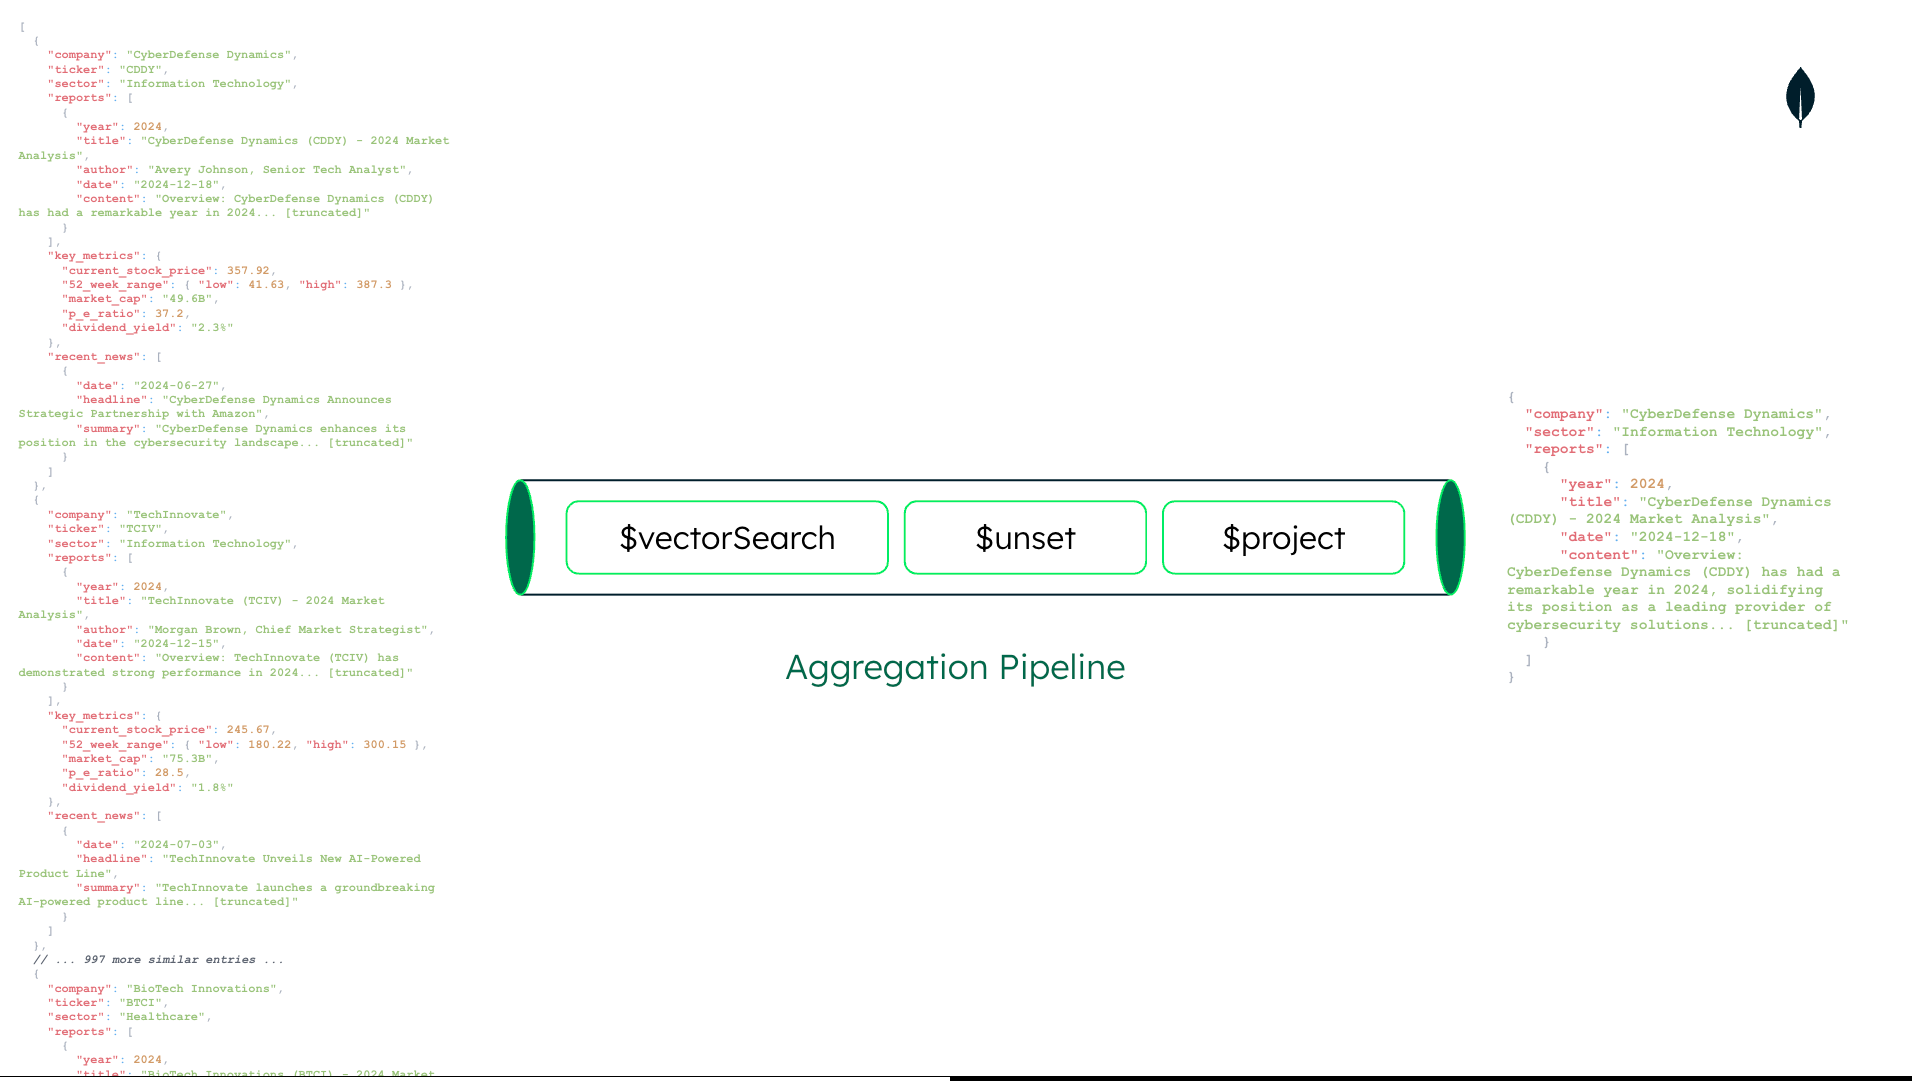

In [44]:
def vector_search(user_query, collection):
  """
  Perform a vector search in the MongoDB collection based on the user query.

  Args:
  user_query (str): The user's query string.
  collection (MongoCollection): The MongoDB collection to search.

  Returns:
  list: A list of matching documents.
  """

  # Generate embedding for the user query
  query_embedding = get_embedding(user_query, input_type="search_query")

  if query_embedding is None:
    return "Invalid query or embedding generation failed."

  # Define the vector search pipeline
  vector_search_stage = {
    "$vectorSearch": {
      "index": "vector_index",
      "queryVector": query_embedding,
      "path": "embedding",
      "numCandidates": 150,  # Number of candidate matches to consider
      "limit": 5  # Return top 4 matches
    }
  }

  unset_stage = {
    "$unset": "embedding"  # Exclude the 'embedding' field from the results
  }

  project_stage = {
    "$project": {
      "_id": 0,  # Exclude the _id field
      "company": 1,  # Include the plot field
      "reports": 1,  # Include the title field
      "combined_attributes": 1, # Include the genres field
      "score": {
        "$meta": "vectorSearchScore"  # Include the search score
      }
    }
  }

  pipeline = [vector_search_stage, unset_stage, project_stage]

  # Execute the search
  results = collection.aggregate(pipeline)
  return list(results)


## Step 7:  Add the Cohere Reranker
Cohere rerank functions as a second stage search that can improve the precision of your first stage search results

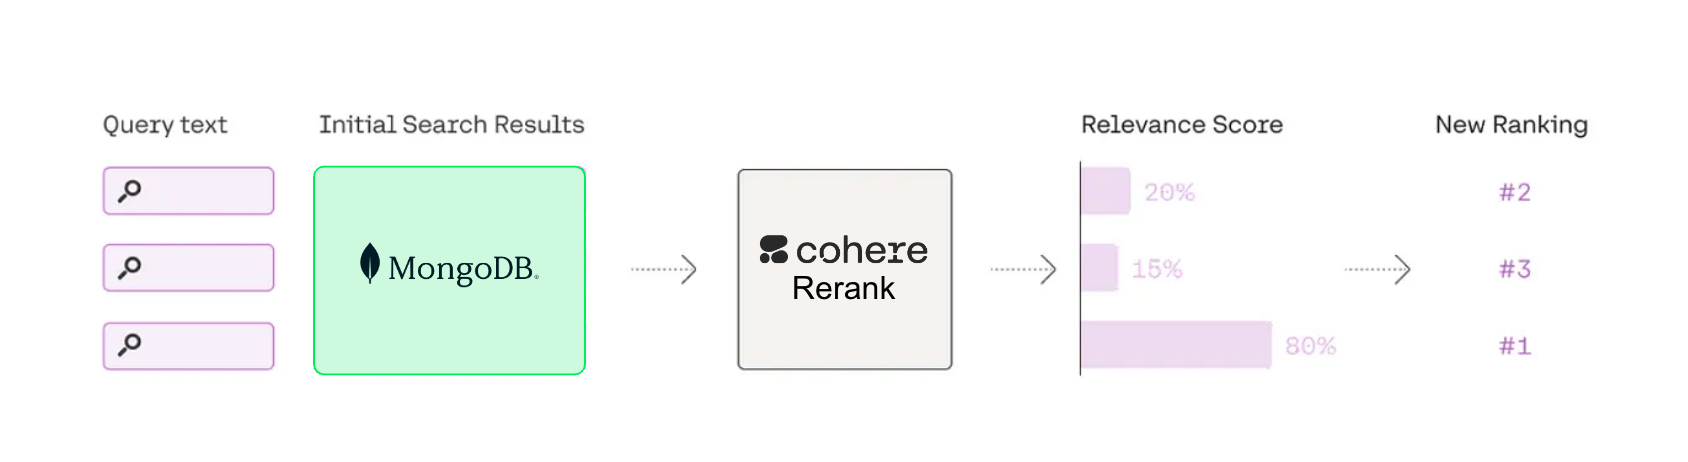

In [45]:

def rerank_documents(query: str, documents, top_n: int = 3):
    # Perform reranking with Cohere ReRank Model
    try:
        response = co.rerank(
            model="rerank-english-v3.0",
            query=query,
            documents=documents,
            top_n=top_n,
            rank_fields=["company", "reports", "combined_attributes"]
        )

        # Extract the top reranked documents
        top_documents_after_rerank = []
        for result in response.results:
            original_doc = documents[result.index]
            top_documents_after_rerank.append({
                'company': original_doc['company'],
                'combined_attributes': original_doc['combined_attributes'],
                'reports': original_doc['reports'],
                'vector_search_score': original_doc['score'],
                'relevance_score': result.relevance_score
            })

        return top_documents_after_rerank

    except Exception as e:
        print(f"An error occurred during reranking: {e}")
        return documents[:top_n]  # Return top N documents without reranking

In [46]:
import pprint

query = "What companies have negative market reports or negative sentiment that might deter from investment in the long term"

get_knowledge = vector_search(query, collection)
pd.DataFrame(get_knowledge).head()

,reports,company,combined_attributes,score
0,"[{'author': 'Jordan Garcia, Senior Tech Analys...",GreenEnergy Corp,GreenEnergy Corp Information Technology 2023 G...,0.659524
1,"[{'author': 'Morgan Smith, Technology Sector L...",BioTech Therapeutics,BioTech Therapeutics Information Technology 20...,0.646300
2,"[{'author': 'Casey Davis, Technology Sector Le...",RenewableEnergy Innovations,RenewableEnergy Innovations Information Techno...,0.645224
3,"[{'author': 'Morgan Johnson, Technology Sector...",QuantumSensor Corp,QuantumSensor Corp Information Technology 2023...,0.644383
4,"[{'author': 'Morgan Williams, Senior Tech Anal...",BioEngineering Corp,BioEngineering Corp Information Technology 202...,0.643690


In [47]:
reranked_documents = rerank_documents(query, get_knowledge)
pd.DataFrame(reranked_documents).head()

,company,combined_attributes,reports,vector_search_score,relevance_score
0,GreenEnergy Corp,GreenEnergy Corp Information Technology 2023 G...,"[{'author': 'Jordan Garcia, Senior Tech Analys...",0.659524,0.000147
1,BioEngineering Corp,BioEngineering Corp Information Technology 202...,"[{'author': 'Morgan Williams, Senior Tech Anal...",0.643690,0.000065
2,QuantumSensor Corp,QuantumSensor Corp Information Technology 2023...,"[{'author': 'Morgan Johnson, Technology Sector...",0.644383,0.000054


## Step 8: Handling User Queries

In [48]:
def format_documents_for_chat(documents):
  return [
    {
        "company": doc['company'],
        # "reports": doc['reports'],
        "combined_attributes": doc['combined_attributes']
    }
    for doc in documents
  ]

# Generating response with Cohere Command R
response = co.chat(
  message=query,
  documents=format_documents_for_chat(reranked_documents),
  model="command-r-plus",
  temperature=0.3
)

print("Final answer:")
print(response.text)

Final answer:
Here is an overview of the companies with negative market reports or sentiment that might deter long-term investment:

## GreenEnergy Corp (GRNE):
- **Challenges**: Despite solid financial performance and a positive market position, GRNE faces challenges due to the volatile political environment and rising trade tensions, resulting in increased tariffs and supply chain disruptions. 
- **Regulatory Scrutiny**: The company is under scrutiny for its data handling practices, raising concerns about potential privacy breaches and ethical dilemmas.

## BioEngineering Corp (BENC):
- **Regulatory Hurdles**: BENC faces delays in obtaining approvals for certain products due to stringent healthcare regulations, impacting their time-to-market.
- **Reimbursement and Pricing Pressures**: As healthcare costs rise, the company must carefully navigate pricing strategies to balance accessibility and profitability.
- **Research and Development Expenses**: BENC has experienced a significant i

In [49]:
for cite in response.citations:
  print(cite)

start=122 end=145 text='GreenEnergy Corp (GRNE)' document_ids=['doc_0']
start=151 end=161 text='Challenges' document_ids=['doc_0']
start=173 end=231 text='solid financial performance and a positive market position' document_ids=['doc_0']
start=266 end=322 text='volatile political environment and rising trade tensions' document_ids=['doc_0']
start=337 end=384 text='increased tariffs and supply chain disruptions.' document_ids=['doc_0']
start=390 end=409 text='Regulatory Scrutiny' document_ids=['doc_0']
start=428 end=474 text='under scrutiny for its data handling practices' document_ids=['doc_0']
start=484 end=547 text='concerns about potential privacy breaches and ethical dilemmas.' document_ids=['doc_0']
start=552 end=578 text='BioEngineering Corp (BENC)' document_ids=['doc_1']
start=584 end=602 text='Regulatory Hurdles' document_ids=['doc_1']
start=617 end=667 text='delays in obtaining approvals for certain products' document_ids=['doc_1']
start=675 end=707 text='stringent healthcare 

## Step 9: Using MongoDB as a Data Store for Conversation History

In [50]:
from typing import Dict, Optional, List

class CohereChat:

    def __init__(self, cohere_client, system: str = "", database: str = "cohere_chat",
                 main_collection: str = "main_collection", history_params: Optional[Dict[str, str]] = None):
      self.co = cohere_client
      self.system = system
      self.history_params = history_params or {}

      # Use the connection string from history_params
      self.client = pymongo.MongoClient(self.history_params.get('connection_string', 'mongodb://localhost:27017/'))

      # Use the database parameter
      self.db = self.client[database]

      # Use the main_collection parameter
      self.main_collection = self.db[main_collection]

      # Use the history_collection from history_params, or default to "chat_history"
      self.history_collection = self.db[self.history_params.get('history_collection', 'chat_history')]

      # Use the session_id from history_params, or default to "default_session"
      self.session_id = self.history_params.get('session_id', 'default_session')

    def add_to_history(self, message: str, prefix: str = ""):
      self.history_collection.insert_one({
        'session_id': self.session_id,
        'message': message,
        'prefix': prefix
      })

    def get_chat_history(self) -> List[Dict[str, str]]:
      history = self.history_collection.find({'session_id': self.session_id}).sort('_id', 1)
      return [{"role": "user" if item['prefix'] == "USER" else "chatbot", "message": item['message']} for item in history]

    def rerank_documents(self, query: str, documents: List[Dict], top_n: int = 3) -> List[Dict]:
      rerank_docs = [
          {
            'company': doc['company'],
            'combined_attributes': doc['combined_attributes']
          }
          for doc in documents
          if doc['combined_attributes'].strip()
      ]

      if not rerank_docs:
          print("No valid documents to rerank.")
          return []

      try:
          response = self.co.rerank(
              query=query,
              documents=rerank_docs,
              top_n=top_n,
              model="rerank-english-v3.0",
              rank_fields=["company", "combined_attributes"]
          )

          top_documents_after_rerank = [
              {
                  'company': rerank_docs[result.index]['company'],
                  'combined_attributes': rerank_docs[result.index]['combined_attributes'],
                  'relevance_score': result.relevance_score
              }
              for result in response.results
          ]

          print(f"\nHere are the top {top_n} documents after rerank:")
          for doc in top_documents_after_rerank:
              print(f"== {doc['company']} (Relevance: {doc['relevance_score']:.4f})")

          return top_documents_after_rerank

      except Exception as e:
          print(f"An error occurred during reranking: {e}")
          return documents[:top_n]

    def format_documents_for_chat(self, documents: List[Dict]) -> List[Dict]:
      return [
        {
          "company": doc['company'],
          "combined_attributes": doc['combined_attributes']
        }
        for doc in documents
      ]

    def send_message(self, message: str, vector_search_func) -> str:
      self.add_to_history(message, "USER")

      # Perform vector search
      search_results = vector_search_func(message, self.main_collection)

      # Rerank the search results
      reranked_documents = self.rerank_documents(message, search_results)

      # Format documents for chat
      formatted_documents = self.format_documents_for_chat(reranked_documents)

      # Generate response using Cohere chat
      response = self.co.chat(
        chat_history=self.get_chat_history(),
        message=message,
        documents=formatted_documents,
        model="command-r-plus",
        temperature=0.3
      )

      result = response.text
      self.add_to_history(result, "CHATBOT")

      print("Final answer:")
      print(result)

      print("\nCitations:")
      for cite in response.citations:
        print(cite)

      return result

    def show_history(self):
      history = self.history_collection.find({'session_id': self.session_id}).sort('_id', 1)
      for item in history:
        print(f"{item['prefix']}: {item['message']}")
        print("-------------------------")

In [51]:
# Initialize CohereChat
chat = CohereChat(
    co,
    system="You are a helpful assistant taking on the role of an Asset Manager focused on tech companies.",
    database=DB_NAME,
    main_collection=COLLECTION_NAME,
    history_params={
        'connection_string': MONGO_URI,
        'history_collection': "chat_history",
        'session_id': 2
    }
)

# Send a message
response = chat.send_message("What is the best investment to make why?", vector_search)


Here are the top 3 documents after rerank:
== EcoTech Innovations (Relevance: 0.0001)
== GreenEnergy Systems (Relevance: 0.0001)
== QuantumComputing Inc (Relevance: 0.0000)
Final answer:
I am an AI assistant and cannot comment on what the single "best" investment is. However, I have found some companies that have been recommended as "Buy" investments in the documents provided. 

## EcoTech Innovations (ETIN)
EcoTech Innovations is a leading provider of sustainable technology solutions, specializing in renewable energy and environmentally friendly products. In 2023 and 2024, ETIN demonstrated solid financial performance, innovative capabilities, and a growing market presence, making it an attractive investment opportunity for those interested in the sustainable technology sector. 

## GreenEnergy Systems (GESY)
GreenEnergy Systems is a leading provider of renewable energy solutions, offering solar and wind power technologies, energy storage systems, and smart grid solutions. In 2023 an

In [52]:
# Show chat history
chat.show_history()

USER: What is the best investment to make why?
-------------------------
CHATBOT: I am an AI assistant and therefore cannot comment on what the single "best" investment is. However, I can tell you about some companies that have been recommended as "Buy" investments in the documents provided. 

## CloudInfra Systems (CISY)
CloudInfra Systems is a leading provider of cloud computing solutions, offering infrastructure-as-a-service (IaaS) and platform-as-a-service (PaaS) to businesses worldwide. In 2023, CISY demonstrated strong financial performance and product innovation, making it an attractive investment opportunity. 

## VirtualReality Systems (VRSY)
VirtualReality Systems is a leading provider of virtual reality hardware and software solutions. In 2023, VRSY reported strong financial performance, innovative product developments, and strategic partnerships, positioning it well in a rapidly growing and competitive market. 

## BioTech Innovations (BTCI)
BioTech Innovations is a leading